In [1]:
#참고: https://programmers.co.kr/learn/courses/21/lessons/1697

from google.colab import drive
import os
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
from gensim.test.utils import datapath, get_tmpfile
#feature_data = datapath('/content/gdrive/My Drive/AI/kaggle/' + '300features_40minwords_10text') 
train_file = datapath('/content/gdrive/My Drive/AI/kaggle/' + 'labeledTrainData.tsv') 
test_file = datapath('/content/gdrive/My Drive/AI/kaggle/' + 'testData.tsv') 
unlabeled_file = datapath('/content/gdrive/My Drive/AI/kaggle/' + 'unlabeledTrainData.tsv') 

print(train_file)

/content/gdrive/My Drive/AI/kaggle/labeledTrainData.tsv


In [17]:
import pandas as pd
import numpy as np

train_data = pd.read_csv(train_file, header=0, delimiter='\t', quoting=3)
test_data = pd.read_csv(test_file, header=0, delimiter='\t', quoting=3)
unlabeled_train_data = pd.read_csv(unlabeled_file, header=0, delimiter='\t', quoting=3)

print(np.array(train_data).shape)
print(np.array(test_data).shape)
print(np.array(unlabeled_train_data).shape)

print(train_daata)
print(test_data)
print(unlabeled_train_data)

(25000, 3)
(25000, 2)
(50000, 2)
              id  sentiment                                             review
0       "5814_8"          1  "With all this stuff going down at the moment ...
1       "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2       "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3       "3630_4"          0  "It must be assumed that those who praised thi...
4       "9495_8"          1  "Superbly trashy and wondrously unpretentious ...
...          ...        ...                                                ...
24995   "3453_3"          0  "It seems like more consideration has gone int...
24996   "5064_1"          0  "I don't believe they made this film. Complete...
24997  "10905_3"          0  "Guy is a loser. Can't get girls, needs to bui...
24998  "10194_3"          0  "This 30 minute documentary Buñuel made in the...
24999   "8478_8"          1  "I saw this movie as a child and it broke my h...

[25000 rows x 3 co

In [0]:
#참고: https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/KaggleWord2VecUtility.py

import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from multiprocessing import Pool

class KaggleWord2VecUtility(object):

    @staticmethod
    def review_to_wordlist(review, remove_stopwords=False):
        # 1. HTML 제거
        review_text = BeautifulSoup(review, "html.parser").get_text()
        # 2. 특수문자를 공백으로 바꿔줌
        review_text = re.sub('[^a-zA-Z]', ' ', review_text)
        # 3. 소문자로 변환 후 나눈다.
        words = review_text.lower().split()
        # 4. 불용어 제거
        if remove_stopwords:
            stops = set(stopwords.words('english'))
            words = [w for w in words if not w in stops]
        # 5. 어간추출
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]
        # 6. 리스트 형태로 반환
        return(words)

    @staticmethod
    def review_to_join_words( review, remove_stopwords=False ):
        words = KaggleWord2VecUtility.review_to_wordlist(\
            review, remove_stopwords=False)
        join_words = ' '.join(words)
        return join_words

    @staticmethod
    def review_to_sentences( review, remove_stopwords=False ):
        # punkt tokenizer를 로드한다.
        """
        이 때, pickle을 사용하는데
        pickle을 통해 값을 저장하면 원래 변수에 연결 된 참조값 역시 저장된다.
        저장된 pickle을 다시 읽으면 변수에 연결되었던
        모든 레퍼런스가 계속 참조 상태를 유지한다.
        """
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        # 1. nltk tokenizer를 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
        raw_sentences = tokenizer.tokenize(review.strip())
        # 2. 각 문장을 순회한다.
        sentences = []
        for raw_sentence in raw_sentences:
            # 비어있다면 skip
            if len(raw_sentence) > 0:
                # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
                sentences.append(\
                    KaggleWord2VecUtility.review_to_wordlist(\
                    raw_sentence, remove_stopwords))
        return sentences


    # 참고 : https://gist.github.com/yong27/7869662
    # http://www.racketracer.com/2016/07/06/pandas-in-parallel/
    # 속도 개선을 위해 멀티 스레드로 작업하도록
    @staticmethod
    def _apply_df(args):
        df, func, kwargs = args
        return df.apply(func, **kwargs)

    @staticmethod
    def apply_by_multiprocessing(df, func, **kwargs):
        # 키워드 항목 중 workers 파라메터를 꺼냄
        workers = kwargs.pop('workers')
        # 위에서 가져온 workers 수로 프로세스 풀을 정의
        pool = Pool(processes=workers)
        # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
        result = pool.map(KaggleWord2VecUtility._apply_df, [(d, func, kwargs)
                for d in np.array_split(df, workers)])
        pool.close()
        # 작업 결과를 합쳐서 반환
        return pd.concat(result)

In [0]:
from nltk.tokenize.regexp import RegexpTokenizer 
tokenizer = RegexpTokenizer("\s+", gaps=True)

sentences = []
for review in train_data["review"]:
    sentences += [KaggleWord2VecUtility.review_to_wordlist(review, remove_stopwords=False)]

for review in unlabeled_train_data["review"]:
    sentences += [KaggleWord2VecUtility.review_to_wordlist(review, remove_stopwords=False)]


In [73]:
print(len(sentences))
print(sentences[0][:10])
print(sentences[1][:10])

75000
['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']
['the', 'classic', 'war', 'of', 'the', 'world', 'by', 'timothi', 'hine', 'is']


In [54]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences, 
                          workers=num_workers, 
                          size=num_features, 
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling,
                          sg = 0) #0:CBOW(skip-gram보다 빠름), 1:skip-gram(느리지만 성능이 더좋음?)
print(model)

In [62]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

model_name = '300features_40minwords_10text_20200209'
model.save(model_name)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [60]:
ls -alrt

total 59356
drwxr-xr-x 1 root root     4096 Feb  5 18:37 sample_data/
drwxr-xr-x 1 root root     4096 Feb  6 17:12 .config/
drwxr-xr-x 1 root root     4096 Feb  8 22:22 ../
drwx------ 4 root root     4096 Feb  8 22:29 gdrive/
drwxr-xr-x 1 root root     4096 Feb  8 23:34 ./
-rw-r--r-- 1 root root 60758781 Feb  8 23:34 300features_40minwords_10text_20200209


In [56]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child kitchen'.split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'kitchen'

In [57]:
model.wv.doesnt_match("france england germany berlin".split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'berlin'

In [58]:
# 가장 유사한 단어를 추출
model.wv.most_similar("man")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.5973883271217346),
 ('lad', 0.5450360774993896),
 ('lady', 0.5308155417442322),
 ('farmer', 0.4986487627029419),
 ('monk', 0.485055148601532),
 ('soldier', 0.4842223823070526),
 ('men', 0.4791395366191864),
 ('guy', 0.4775075614452362),
 ('chap', 0.47071129083633423),
 ('millionaire', 0.4638359248638153)]

In [63]:
# 참고 https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
import gensim 
import gensim.models as g

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

#model_name = '300features_40minwords_10text'
model = g.Doc2Vec.load(model_name)

vocab = list(model.wv.vocab)
X = model[vocab]

print(len(X))
print(X[0][:10])
tsne = TSNE(n_components=2)

# 100개의 단어에 대해서만 시각화
X_tsne = tsne.fit_transform(X[:100,:])
# X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab[:100], columns=['x', 'y'])
print(df.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


16490
[-0.0670943   0.09199936 -0.19003129  0.00588231  0.04025528  0.0731952
 -0.06354948 -0.07427695  0.03566811 -0.00604562]
(100, 2)


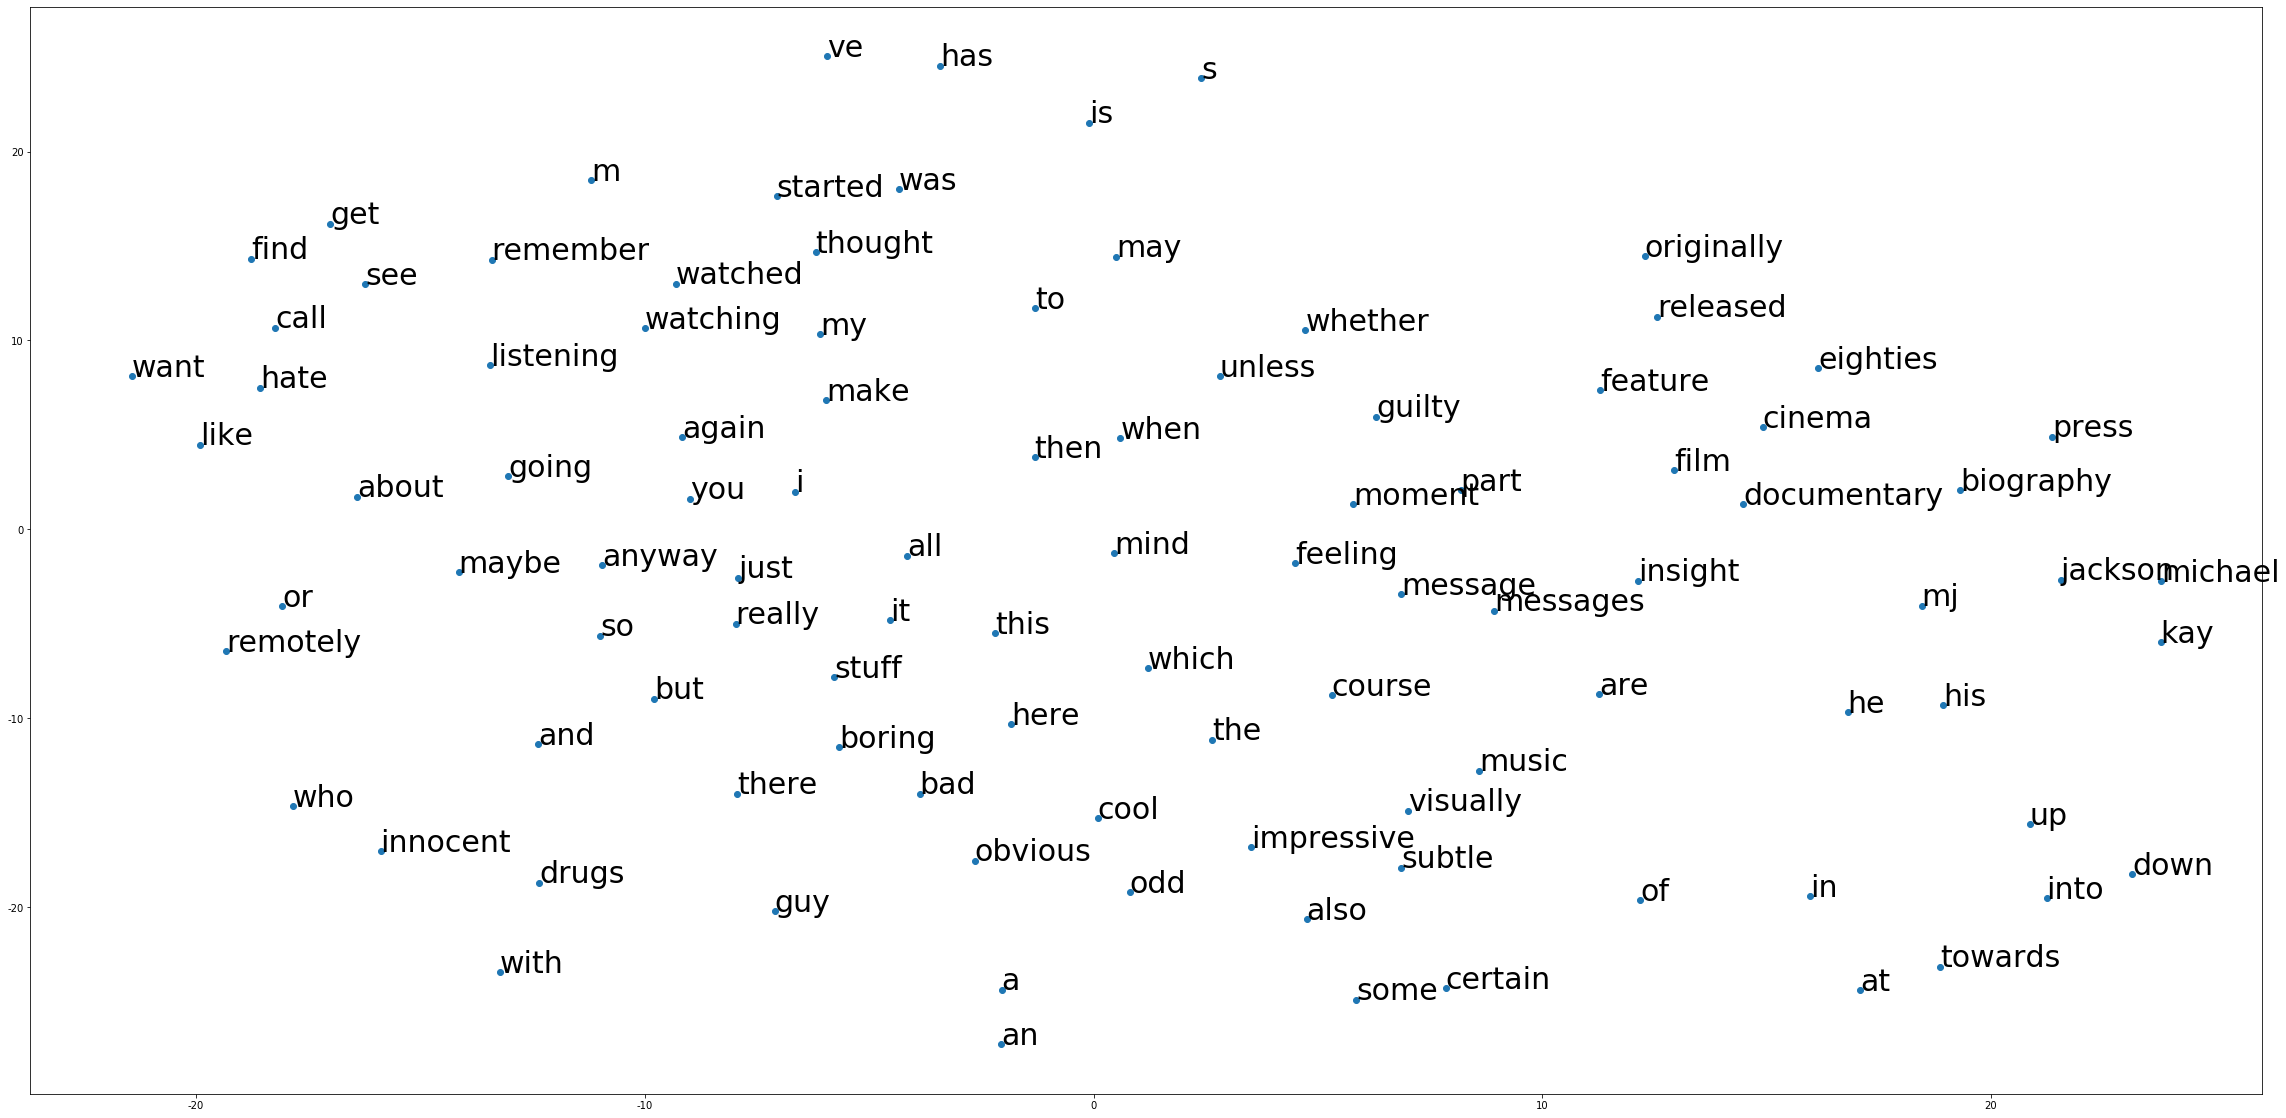

In [64]:
fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize=30)
plt.show()

In [0]:
import numpy as np

def makeFeatureVec(words, model, num_features):
    """
    주어진 문장에서 단어 벡터의 평균을 구하는 함수
    """
    # 속도를 위해 0으로 채운 배열로 초기화한다.
    featureVec = np.zeros((num_features,),dtype="float32")

    nwords = 0.
    # Index2word는 모델의 사전에 있는 단어 명을 담은 리스트이다.
    # 속도를 위해 set 형태로 초기화한다.
    index2word_set = set(model.wv.index2word)
    # 루프를 돌며 모델 사전에 포함이 되는 단어라면 피처에 추가한다.
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 결과를 단어 수로 나누어 평균을 구한다.
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [0]:
def getAvgFeatureVecs(reviews, model, num_features):
    # 리뷰 단어 목록의 각각에 대한 평균 feature 벡터를 계산하고 
    # 2D numpy 배열을 반환한다.

    # 카운터를 초기화한다.
    counter = 0.
    # 속도를 위해 2D 넘파이 배열을 미리 할당한다.
    reviewFeatureVecs = np.zeros(
        (len(reviews),num_features),dtype="float32")

    for review in reviews:
       # 매 1000개 리뷰마다 상태를 출력
       if counter%1000. == 0.:
           print("Review %d of %d" % (counter, len(reviews)))
       # 평균 피처 벡터를 만들기 위해 위에서 정의한 함수를 호출한다.
       reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, \
           num_features)
       # 카운터를 증가시킨다.
       counter = counter + 1.
    return reviewFeatureVecs

In [0]:
# 멀티스레드로 4개의 워커를 사용해 처리한다.
def getCleanReviews(reviews):
    clean_reviews = []
    clean_reviews = KaggleWord2VecUtility.apply_by_multiprocessing(\
        reviews["review"], KaggleWord2VecUtility.review_to_wordlist,\
        workers=4)
    return clean_reviews

In [77]:
%time trainDataVecs = getAvgFeatureVecs( getCleanReviews(train_data), model, num_features ) 

Review 0 of 25000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 56.2 s, sys: 9.25 s, total: 1min 5s
Wall time: 2min 18s


In [79]:
%time testDataVecs = getAvgFeatureVecs(getCleanReviews(test_data), model, num_features )

Review 0 of 25000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
CPU times: user 54.4 s, sys: 2.09 s, total: 56.5 s
Wall time: 2min 4s


In [81]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=2018)

%time forest = forest.fit( trainDataVecs, train_data["sentiment"] )

CPU times: user 1min 10s, sys: 66.9 ms, total: 1min 10s
Wall time: 35.7 s


In [83]:
from sklearn.model_selection import cross_val_score
%time score = np.mean(cross_val_score(\
    forest, trainDataVecs, \
    train_data['sentiment'], cv=10, scoring='roc_auc'))

print(score)

CPU times: user 5.59 s, sys: 846 ms, total: 6.44 s
Wall time: 5min 25s
0.8747464319999999


In [0]:
result = forest.predict( testDataVecs )

In [0]:
output = pd.DataFrame( data={"id":test_data["id"], "sentiment":result}) #, "review":test_data["review"] 
output.to_csv('Word2Vec_AverageVectors_{0:.5f}.csv'.format(score), index=False, quoting=3 )

In [95]:
ls -alrt

total 59636
drwxr-xr-x 1 root root     4096 Feb  5 18:37 sample_data/
drwxr-xr-x 1 root root     4096 Feb  6 17:12 .config/
drwx------ 4 root root     4096 Feb  8 22:29 gdrive/
-rw-r--r-- 1 root root 60758847 Feb  8 23:54 300features_40minwords_10text_20200209
drwxr-xr-x 1 root root     4096 Feb  9 01:02 ../
drwxr-xr-x 1 root root     4096 Feb  9 01:03 ./
-rw-r--r-- 1 root root   282792 Feb  9 01:03 Word2Vec_AverageVectors_0.87475.csv


In [0]:
from google.colab import files
files.download("/content/Word2Vec_AverageVectors_0.87475.csv")

In [98]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0] - output_sentiment[1])
output_sentiment

196


0    12598
1    12402
Name: sentiment, dtype: int64

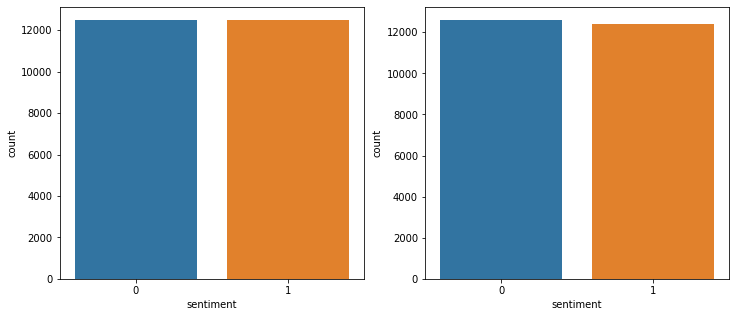

In [100]:
import seaborn as sns 
%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train_data['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])